##### Expand View


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [2]:
# Exploring MNIST Gans

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST  # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist_01')

import matplotlib.pyplot as plt
# import wandb

from markipy.nn.gans.generator import get_gen_loss, Generator
from markipy.nn.gans.discriminator import get_disc_loss, Discriminator
from markipy.nn.commons import show_tensor_images, make_noise
from markipy.basic import date


torch.manual_seed(0)  # Set for testing purposes, please do not change!

PROJECT="MNIST"
VERSIONE="0.1"
RUN="11"

# default `log_dir` is "runs" - we'll be more specific here\
logs=f'runs/{PROJECT}_{VERSIONE}.{date()}#{RUN}'

writer = SummaryWriter(logs)
print(f"Logs at: {logs}")


Logs at: runs/MNIST_0.1.2020.10.25#10


## Hyperparameters

In [3]:
    # Mnist Playground
    device = torch.device('cuda')
    n_epochs = 100
    noise_c = 1 
    noise_w = noise_b = 8
    z_dim = (noise_c, noise_w, noise_b)
    display_step = 468
    log_step = 10
    batch_size = 32
    lr = 0.00001
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    test_generator = False  # Whether the generator should be tested
    gen_loss = False
    error = False

## Load Data

In [4]:
    # Load MNIST dataset as tensors
    dataloader = DataLoader(
        MNIST('.', download=True, transform=transforms.ToTensor()),
        batch_size=batch_size,
        shuffle=True)

## Core

In [5]:
    criterion = nn.BCEWithLogitsLoss()
    gen = Generator(noise_c).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

# Generator Details

In [6]:
from pytorch_model_summary import summary
n_sample = 1
noise_input = make_noise( n_sample, (noise_c, noise_w, noise_b), device='cuda')

print(summary(gen, noise_input,  show_input=True))
print(summary(gen, noise_input,  show_input=False))

--------------------------------------------------------------------------
         Layer (type)         Input Shape         Param #     Tr. Param #
             Conv2d-1        [1, 1, 8, 8]             100             100
        BatchNorm2d-2       [1, 10, 8, 8]              20              20
               ReLU-3       [1, 10, 8, 8]               0               0
    ConvTranspose2d-4       [1, 10, 8, 8]           2,259           2,259
        BatchNorm2d-5      [1, 9, 12, 12]              18              18
               ReLU-6      [1, 9, 12, 12]               0               0
    ConvTranspose2d-7      [1, 9, 12, 12]           1,808           1,808
        BatchNorm2d-8      [1, 8, 16, 16]              16              16
    ConvTranspose2d-9      [1, 8, 16, 16]           1,407           1,407
       BatchNorm2d-10      [1, 7, 20, 20]              14              14
   ConvTranspose2d-11      [1, 7, 20, 20]           1,056           1,056
       BatchNorm2d-12      [1, 6, 24,

# Discriminator Details

In [7]:
from pytorch_model_summary import summary
n_sample = 1
_input = make_noise( n_sample, ( 1, 28 * 28), device='cuda')

print(summary(disc, _input,  show_input=True))
print(summary(disc, _input,  show_input=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1         [1, 1, 784]         100,480         100,480
       LeakyReLU-2         [1, 1, 128]               0               0
          Linear-3         [1, 1, 128]           8,256           8,256
       LeakyReLU-4          [1, 1, 64]               0               0
          Linear-5          [1, 1, 64]           2,080           2,080
       LeakyReLU-6          [1, 1, 32]               0               0
          Linear-7          [1, 1, 32]              33              33
Total params: 110,849
Trainable params: 110,849
Non-trainable params: 0
-----------------------------------------------------------------------
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1         [1, 1, 128]         100,480         100,480
  

## View Input Data

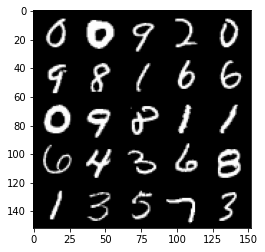

torch.Size([32, 1, 28, 28]) torch.Size([32]) tensor([0, 0, 9, 2, 0, 9, 8, 1, 6, 6, 0, 9, 8, 1, 1, 6, 4, 3, 6, 8, 1, 3, 5, 7,
        3])


In [8]:
for x,y in dataloader:
    show_tensor_images(x, num_images=25)
    print(x.shape, y.shape, y[:25])
    break
    

# Train - 1 Step

In [10]:
disc_init = False
for epoch in range(n_epochs):
    
    # Dataloader returns the batches
    bar = tqdm(dataloader)
    for real, label in bar:
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        if cur_step % 300: 
            ### Update discriminator ###
            # Zero out the gradients before backpropagation
            disc_opt.zero_grad()

            # Calculate discriminator loss
            disc_loss = get_disc_loss(gen, disc, criterion, real, label, cur_batch_size, z_dim, device)

            # Update gradients
            disc_loss.backward(retain_graph=True)

            # Update optimizer
            disc_opt.step()
            
            disc_init = True

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Update gradients
        gen_opt.zero_grad()

        # Update optimizer
        gen_loss = get_gen_loss(gen, disc, criterion, label, cur_batch_size, z_dim, device)

        # Update gradients
        gen_loss.backward(retain_graph=True)

        # Update optimizer
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
                
            except:
                error = True
                
                # wandb.log({"no_training": 1, "epoch": epoch, "loss": loss})
                print("Runtime tests have failed")

        if disc_init:
            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:


            noise = make_noise(cur_batch_size, z_dim, device=device)
            fake = gen(noise)
            
            show_tensor_images(fake)
            show_tensor_images(real)
            
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            

        
        if cur_step % log_step == 0 and log_step > 0:
            # wandb.log({ "Epoch" : epoch, "step": cur_step , "Generator_Loss" : mean_generator_loss, "Discriminator_Loss": mean_discriminator_loss })
            bar.set_description(f"Epoch {epoch}, step {cur_step}: GenL: {mean_generator_loss if disc_init else 'nan'}, DisL: {mean_discriminator_loss}")
            # Tensorboard
            writer.add_scalar('mean_generator loss', mean_generator_loss, cur_step)
            writer.add_scalar('mean_discriminator_loss loss', mean_discriminator_loss, cur_step)
        
        # Increase step
        cur_step += 1
    
        
        
# Shift + o  : To show scroll the ouput 

Epoch 0, step 7900: GenL: 9.596790444137707, DisL: 0.00010262377051738932:   4%|▍         | 83/1875 [00:01<00:40, 44.17it/s]


KeyboardInterrupt: 

In [16]:
real.shape
real = real.reshape(real.shape[0], 1, 28, 28)
real.shape

torch.Size([32, 1, 28, 28])

In [33]:
from markipy.nn.commons import get_conv2d_block
cv1 = get_conv2d_block(1, 5, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out1 = cv1(real)
out1.shape

torch.Size([32, 5, 28, 28])

In [34]:
cv2 = get_conv2d_block(5, 10, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out2 = cv2(out1)
m2 = nn.MaxPool2d((3, 3), stride=(1, 1))
out2 = m2(out2)
out2.shape

torch.Size([32, 10, 26, 26])

In [35]:
cv3 = get_conv2d_block(10, 20, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out3 = cv3(out2)
m3 = nn.MaxPool2d((3, 3), stride=(1, 1))
out3 = m2(out3)
out3.shape

torch.Size([32, 20, 24, 24])

In [37]:
cv4 = get_conv2d_block(20, 10, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out4 = cv4(out3)
m4 = nn.MaxPool2d((3, 3), stride=(1, 1))
out4 = m4(out4)
out4.shape

torch.Size([32, 10, 22, 22])

In [40]:
cv5 = get_conv2d_block(10, 2, ks=5, normalize=False, activation=nn.LeakyReLU(0.2)).cuda()
out5 = cv5(out4)
m5 = nn.MaxPool2d((3, 3), stride=(1, 1))
out5 = m5(out5)
out5.shape

torch.Size([32, 2, 20, 20])